In [1]:
# ========== BD Weather full pipeline (single-cell, no functions) ==========
import os, json, joblib, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

RANDOM_STATE = 42

# optional boosters
HAS_XGB = False
HAS_LGB = False
HAS_CAT = False
try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    pass
try:
    import lightgbm as lgb
    HAS_LGB = True
except Exception:
    pass
try:
    import catboost as cb
    HAS_CAT = True
except Exception:
    pass

# ----------------- USER CONFIG -----------------
DATA_PATH = './Dataset/BD_weather.csv'   # your dataset path
OUTPUT_DIR = './bd_weather_output'       # where to save model & reports
TIME_SPLIT = True                        # if True and Date exists: use time-based split
TEST_SIZE = 0.20
MAX_SAMPLE_ROWS = None                   # set to int for faster dev, e.g., 20000
FAST = True                              # if True: smaller/higher-level tuning (faster)
TUNE_TOP_K = 2                           # how many top models to tune
# ------------------------------------------------

print("Loading dataset from:", DATA_PATH)
df = pd.read_csv(DATA_PATH)
print("Rows:", len(df), "Columns:", df.columns.tolist())
print()

Loading dataset from: ./Dataset/BD_weather.csv
Rows: 543839 Columns: ['Station', 'Year', 'Month', 'Day', 'Rainfall', 'Sunshine', 'Humidity', 'Temperature']



In [2]:
# ---------- Ensure Date column ----------
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
else:
    # create Date if Year/Month/Day exist
    if all(c in df.columns for c in ['Year','Month','Day']):
        df['Year_tmp'] = pd.to_numeric(df['Year'], errors='coerce')
        df['Month_tmp'] = pd.to_numeric(df['Month'], errors='coerce')
        df['Day_tmp'] = pd.to_numeric(df['Day'], errors='coerce')
        df['Date'] = pd.to_datetime(dict(year=df['Year_tmp'].fillna(1).astype(int),
                                         month=df['Month_tmp'].fillna(1).astype(int),
                                         day=df['Day_tmp'].fillna(1).astype(int)), errors='coerce')
        df.drop(columns=['Year_tmp','Month_tmp','Day_tmp'], inplace=True)
        print("Created Date from Year/Month/Day")
    else:
        print("No Date / Year/Month/Day available; some time-based features & time-split won't be possible.")

# ---------- Basic date & cyclic features ----------
if 'Date' in df.columns and not df['Date'].isnull().all():
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
# cyclic:
if 'Month' in df.columns:
    df['month_sin'] = np.sin(2 * np.pi * (df['Month'].astype(float) / 12.0))
    df['month_cos'] = np.cos(2 * np.pi * (df['Month'].astype(float) / 12.0))
if 'Day' in df.columns:
    df['day_sin'] = np.sin(2 * np.pi * (df['Day'].astype(float) / 31.0))
    df['day_cos'] = np.cos(2 * np.pi * (df['Day'].astype(float) / 31.0))

# ---------- Create target ----------
if 'RainBinary' in df.columns:
    target_col = 'RainBinary'
else:
    if 'Rainfall' in df.columns:
        df['RainBinary'] = (pd.to_numeric(df['Rainfall'], errors='coerce') > 0.0).astype(int)
        target_col = 'RainBinary'
        print("Created binary target 'RainBinary' from 'Rainfall'>0")
    else:
        # fallback: try last column binary if it has 2 unique values
        last = df.columns[-1]
        if df[last].nunique() == 2:
            target_col = last
            print("Using last column as target:", target_col)
        else:
            raise ValueError("Cannot infer target. Provide 'Rainfall' or 'RainBinary' in dataset.")

print("Target:", target_col, "class distribution:\n", df[target_col].value_counts(normalize=True).to_dict())

Created Date from Year/Month/Day
Created binary target 'RainBinary' from 'Rainfall'>0
Target: RainBinary class distribution:
 {0: 0.6764483606361441, 1: 0.32355163936385584}


In [3]:
# ---------- Sort for lags ----------
if 'Station' in df.columns and 'Date' in df.columns:
    df = df.sort_values(['Station','Date']).reset_index(drop=True)
elif 'Date' in df.columns:
    df = df.sort_values(['Date']).reset_index(drop=True)
else:
    df = df.reset_index(drop=True)

# ---------- Create station-aware lags & rolling features ----------
cols_to_lag = [c for c in ['Rainfall','Temperature','Humidity'] if c in df.columns]
lags = [1,2,3]
rolling_windows = [3,7]

if 'Station' in df.columns:
    grpcol = 'Station'
    for c in cols_to_lag:
        for lag in lags:
            df[f'{c}_lag{lag}'] = df.groupby(grpcol)[c].shift(lag)
        for w in rolling_windows:
            df[f'{c}_rollmean_{w}'] = df.groupby(grpcol)[c].shift(1).rolling(window=w, min_periods=1).mean().reset_index(level=0, drop=True)
else:
    # global lags/rolling
    for c in cols_to_lag:
        for lag in lags:
            df[f'{c}_lag{lag}'] = df[c].shift(lag)
        for w in rolling_windows:
            df[f'{c}_rollmean_{w}'] = df[c].shift(1).rolling(window=w, min_periods=1).mean()

print("Added lag/rolling features for:", cols_to_lag)

Added lag/rolling features for: ['Rainfall', 'Temperature', 'Humidity']


In [4]:
# ---------- Optional sampling for faster dev (set MAX_SAMPLE_ROWS variable above) ----------
if MAX_SAMPLE_ROWS and len(df) > MAX_SAMPLE_ROWS:
    # stratified sample by target to keep balance
    df0 = df[df[target_col] == 0]
    df1 = df[df[target_col] == 1]
    n1 = max(1, int(MAX_SAMPLE_ROWS * (len(df1) / len(df))))
    n0 = max(1, MAX_SAMPLE_ROWS - n1)
    df = pd.concat([df0.sample(n=n0, random_state=RANDOM_STATE), df1.sample(n=n1, random_state=RANDOM_STATE)])
    df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    print("Downsampled to", len(df), "rows for faster dev.")

# ---------- Prepare features: exclude target, Date and optionally Rainfall to avoid leakage ----------
exclude = {target_col, 'Date'}
if 'Rainfall' in df.columns and target_col != 'Rainfall':
    exclude.add('Rainfall')
candidate_features = [c for c in df.columns if c not in exclude]

print("Candidate features ({}): {}".format(len(candidate_features), candidate_features))

Candidate features (28): ['Station', 'Year', 'Month', 'Day', 'Sunshine', 'Humidity', 'Temperature', 'DayOfYear', 'WeekOfYear', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'Rainfall_lag1', 'Rainfall_lag2', 'Rainfall_lag3', 'Rainfall_rollmean_3', 'Rainfall_rollmean_7', 'Temperature_lag1', 'Temperature_lag2', 'Temperature_lag3', 'Temperature_rollmean_3', 'Temperature_rollmean_7', 'Humidity_lag1', 'Humidity_lag2', 'Humidity_lag3', 'Humidity_rollmean_3', 'Humidity_rollmean_7']


In [5]:
# ---------- Split: time-based if requested and Date present, else stratified random ----------
if TIME_SPLIT and 'Date' in df.columns:
    split_index = int(len(df) * (1.0 - TEST_SIZE))
    train_df = df.iloc[:split_index].reset_index(drop=True)
    test_df = df.iloc[split_index:].reset_index(drop=True)
    X_train = train_df[candidate_features]
    X_test = test_df[candidate_features]
    y_train = train_df[target_col]
    y_test = test_df[target_col]
    print(f"Time-split: train {len(X_train)} rows, test {len(X_test)} rows.")
else:
    X = df[candidate_features]
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)
    print(f"Random stratified split: train {len(X_train)} rows, test {len(X_test)} rows.")

# ---------- Identify numeric & categorical ----------
numeric_cols = [c for c in X_train.columns if np.issubdtype(X_train[c].dtype, np.number)]
categorical_cols = [c for c in X_train.columns if not np.issubdtype(X_train[c].dtype, np.number)]
print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

Time-split: train 435071 rows, test 108768 rows.
Numeric cols: ['Year', 'Month', 'Day', 'Sunshine', 'Humidity', 'Temperature', 'DayOfYear', 'WeekOfYear', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'Rainfall_lag1', 'Rainfall_lag2', 'Rainfall_lag3', 'Rainfall_rollmean_3', 'Rainfall_rollmean_7', 'Temperature_lag1', 'Temperature_lag2', 'Temperature_lag3', 'Temperature_rollmean_3', 'Temperature_rollmean_7', 'Humidity_lag1', 'Humidity_lag2', 'Humidity_lag3', 'Humidity_rollmean_3', 'Humidity_rollmean_7']
Categorical cols: ['Station']


In [6]:
# ---------- Build preprocessors (handle OneHotEncoder param compatibility) ----------
# sklearn version compatibility for OneHotEncoder param name (sparse vs sparse_output)
ohe_params = None
try:
    # try new param name
    OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ohe_params = {'handle_unknown': 'ignore', 'sparse_output': False}
except TypeError:
    # fallback to older param name
    ohe_params = {'handle_unknown': 'ignore', 'sparse': False}

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(**ohe_params))])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
], remainder='drop', verbose_feature_names_out=False)

# ---------- Model candidates ----------
models = {}
models['logreg'] = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
models['rf'] = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
models['gb'] = GradientBoostingClassifier(random_state=RANDOM_STATE)
if HAS_XGB:
    models['xgb'] = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE, n_jobs=-1)
if HAS_LGB:
    models['lgb'] = lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1)
if HAS_CAT:
    models['cat'] = cb.CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)

print("Model candidates:", list(models.keys()))

Model candidates: ['logreg', 'rf', 'gb', 'xgb', 'lgb', 'cat']


In [7]:
# ---------- Baseline cross-validated comparison ----------
cv_folds = 4 if FAST else 5
baseline_scores = {}
for name, estimator in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_sel', SelectFromModel(RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE), threshold='median')),
        ('clf', estimator)
    ])
    print("CV for:", name)
    try:
        scores = cross_val_score(pipe, X_train, y_train, cv=cv_folds, scoring='accuracy', n_jobs=-1)
        baseline_scores[name] = float(np.mean(scores))
        print(f"  mean CV accuracy: {baseline_scores[name]:.4f}")
    except Exception as e:
        print("  failed CV for", name, ":", e)
        baseline_scores[name] = None

print("Baseline results:", baseline_scores)

CV for: logreg
  mean CV accuracy: 0.8552
CV for: rf
  mean CV accuracy: 0.8736
CV for: gb
  mean CV accuracy: 0.8659
CV for: xgb
  mean CV accuracy: 0.8718
CV for: lgb
  mean CV accuracy: 0.8717
CV for: cat
  mean CV accuracy: 0.8747
Baseline results: {'logreg': 0.8552305215802728, 'rf': 0.873556269574588, 'gb': 0.8658517812303488, 'xgb': 0.8717933394917414, 'lgb': 0.8716853095778857, 'cat': 0.874657240574592}


In [8]:
# ---------- Choose top-K to tune ----------
valid_baseline = {k:v for k,v in baseline_scores.items() if v is not None}
top_k_names = sorted(valid_baseline.items(), key=lambda x: x[1], reverse=True)[:TUNE_TOP_K]
top_k_names = [k for k,_ in top_k_names]
print("Top candidates to tune:", top_k_names)

# ---------- Tuning via RandomizedSearchCV (per model) ----------
tuned_pipes = {}
for name in top_k_names:
    estimator = models[name]
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_sel', SelectFromModel(RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE), threshold='median')),
        ('clf', estimator)
    ])
    param_dist = {}
    if name == 'rf':
        param_dist = {
            'clf__n_estimators': [100,200,400] if not FAST else [100,200],
            'clf__max_depth': [6,8,12,None] if not FAST else [8,None],
            'clf__min_samples_leaf': [1,3,5,10] if not FAST else [3,10]
        }
    elif name == 'gb':
        param_dist = {
            'clf__n_estimators': [100,200],
            'clf__learning_rate': [0.05,0.1],
            'clf__max_depth': [3,5]
        }
    elif name == 'logreg':
        param_dist = {'clf__C': [0.01,0.1,1.0,10.0]}
    elif name == 'xgb' and HAS_XGB:
        param_dist = {'clf__n_estimators':[100,200], 'clf__max_depth':[3,6,8], 'clf__learning_rate':[0.01,0.05,0.1]}
    elif name == 'lgb' and HAS_LGB:
        param_dist = {'clf__n_estimators':[100,200], 'clf__num_leaves':[31,50], 'clf__learning_rate':[0.01,0.05,0.1]}
    else:
        # fallback: no tuning
        print("No tuning grid for", name, "— fitting default pipeline.")
        pipe.fit(X_train, y_train)
        tuned_pipes[name] = (pipe, None)
        continue

    n_iter = 20 if not FAST else 6
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)
    print("Tuning", name, "with RandomizedSearchCV (n_iter=", n_iter, ") ...")
    search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=n_iter, cv=cv, scoring='accuracy', n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
    search.fit(X_train, y_train)
    print(" Best CV score:", search.best_score_, "best params:", search.best_params_)
    tuned_pipes[name] = (search.best_estimator_, search.best_score_)

Top candidates to tune: ['cat', 'rf']
No tuning grid for cat — fitting default pipeline.
Tuning rf with RandomizedSearchCV (n_iter= 6 ) ...
Fitting 4 folds for each of 6 candidates, totalling 24 fits
 Best CV score: 0.879870179871589 best params: {'clf__n_estimators': 200, 'clf__min_samples_leaf': 3, 'clf__max_depth': None}


In [9]:
# ---------- Evaluate tuned models on test set and pick best ----------
best_name = None
best_test_acc = -1
best_pipe = None
tuned_results = {}
for name, (pipe, score) in tuned_pipes.items():
    print("Evaluating on test:", name)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    try:
        proba = pipe.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, proba)
    except Exception:
        auc = None
    tuned_results[name] = {'test_accuracy': float(acc), 'test_auc': float(auc) if auc is not None else None}
    print(f"  test acc: {acc:.4f}, auc: {auc}")
    if acc > best_test_acc:
        best_test_acc = acc
        best_name = name
        best_pipe = pipe

# Fallback: if no tuned pipes (rare), fit best baseline model on full train
if best_pipe is None and valid_baseline:
    best_name = max(valid_baseline.items(), key=lambda x: x[1])[0]
    print("No tuned model available; using baseline best:", best_name)
    chosen_est = models[best_name]
    pipe = Pipeline([('preprocessor', preprocessor),
                     ('feature_sel', SelectFromModel(RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE), threshold='median')),
                     ('clf', chosen_est)])
    pipe.fit(X_train, y_train)
    best_pipe = pipe
    best_test_acc = accuracy_score(y_test, pipe.predict(X_test))

print("Selected best model:", best_name, "test accuracy:", best_test_acc)

Evaluating on test: cat
  test acc: 0.8703, auc: 0.9451730632645301
Evaluating on test: rf
  test acc: 0.8672, auc: 0.9449803735117318
Selected best model: cat test accuracy: 0.8703203147984702


In [10]:
# ---------- Evaluate & Save ----------
os.makedirs(OUTPUT_DIR, exist_ok=True)
y_pred = best_pipe.predict(X_test)
try:
    proba = best_pipe.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, proba)
except Exception:
    auc = None
acc = accuracy_score(y_test, y_pred)
report = {
    'model_name': best_name,
    'accuracy': float(acc),
    'roc_auc': float(auc) if auc is not None else None,
    'classification_report': classification_report(y_test, y_pred, output_dict=True, zero_division=0),
    'confusion_matrix': confusion_matrix(y_test, y_pred).tolist(),
    'candidate_features': candidate_features,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'baseline_scores': baseline_scores,
    'tuned_results': {k: (v[1] if v[1] is not None else None) for k,v in tuned_pipes.items()}
}
# joblib.dump(best_pipe, os.path.join(OUTPUT_DIR, f'best_{best_name}.joblib'))
# with open(os.path.join(OUTPUT_DIR, f'best_{best_name}_report.json'), 'w') as f:
#     json.dump(report, f, indent=2)
# print("Saved best model and report to:", OUTPUT_DIR)
print("Report summary: accuracy=", report['accuracy'], "auc=", report['roc_auc'])
# print("Files in output dir:", os.listdir(OUTPUT_DIR))
# ================= END OF PIPELINE =================


Report summary: accuracy= 0.8703203147984702 auc= 0.9451730632645301


Found 'best_pipe' in memory - using it.
Found X_test, y_test in memory - using them.

===== Classification report on test set =====
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     70936
           1       0.84      0.77      0.80     37832

    accuracy                           0.87    108768
   macro avg       0.86      0.85      0.85    108768
weighted avg       0.87      0.87      0.87    108768



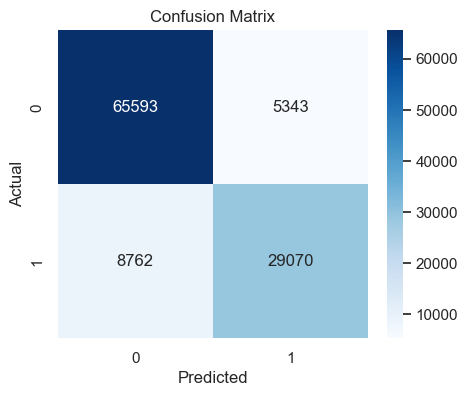

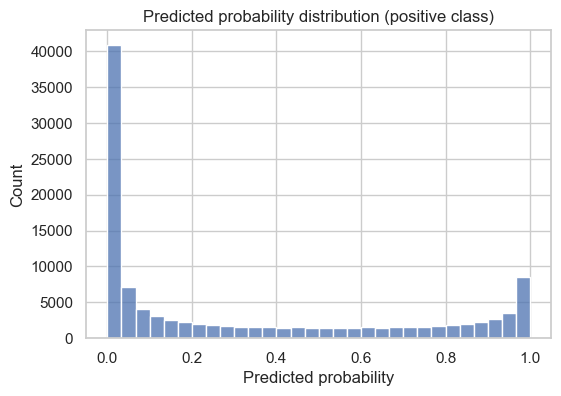

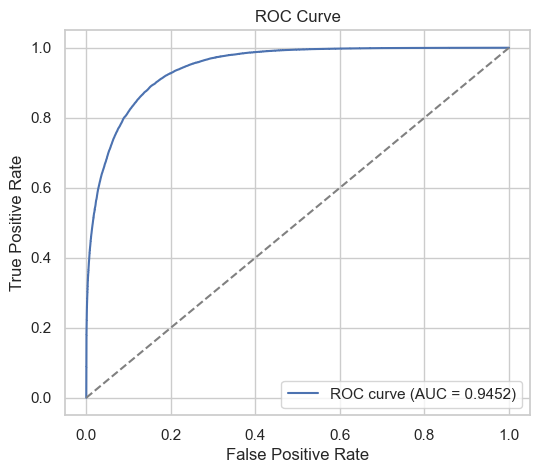

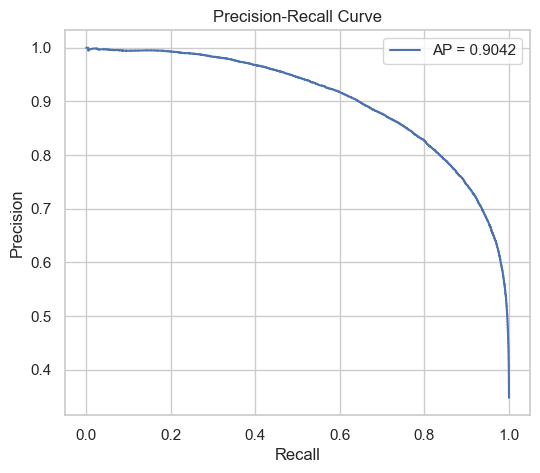

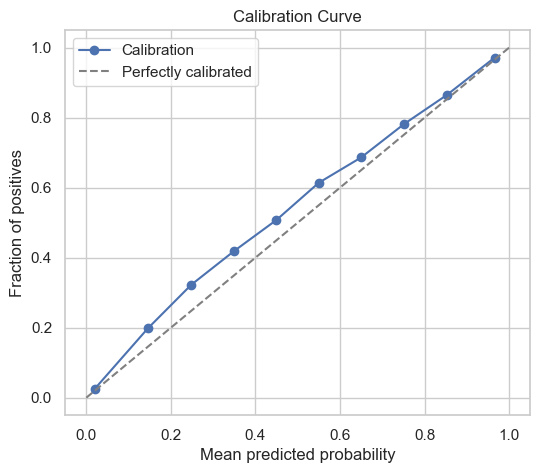

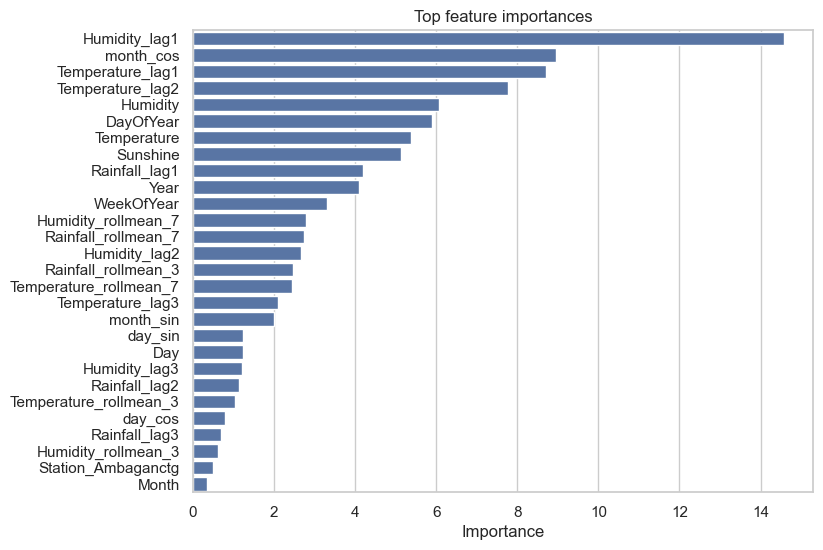

Computing learning curve (this may take a bit)...


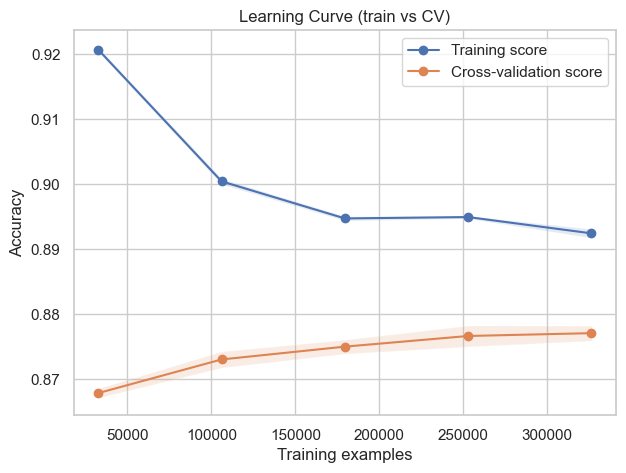

Date not available in dataset; skipping time-series plot.

Summary: model: <class 'sklearn.pipeline.Pipeline'> selected best_test_acc ~=  0.8703203147984702
End of evaluation plots.


In [11]:
# ===== Evaluation & diagnostic plots (single cell) =====
import os, glob, json, joblib, warnings
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score, roc_auc_score)
from sklearn.calibration import calibration_curve
from sklearn.model_selection import learning_curve, StratifiedKFold

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8,5)

# === CONFIG ===
OUTPUT_DIR = './bd_weather_output'  # change if you used different folder
MODEL_GLOB = os.path.join(OUTPUT_DIR, 'best_*.joblib')
META_PATH = os.path.join(OUTPUT_DIR, 'meta.json')
DATA_PATH = './Dataset/BD_weather.csv'  # fallback to rebuild splits if needed
RANDOM_STATE = 42
# =============

# --- helper to load model and data if not in memory ---
try:
    best_pipe  # noqa: F821
    print("Found 'best_pipe' in memory - using it.")
except Exception:
    # try to find saved model
    files = glob.glob(MODEL_GLOB)
    if not files:
        raise FileNotFoundError(f"No model found in {OUTPUT_DIR}. Expected pattern {MODEL_GLOB}")
    model_file = sorted(files)[-1]
    print("Loading model from:", model_file)
    best_pipe = joblib.load(model_file)

# Try to get X_test, y_test from memory. If not, attempt to reconstruct using meta.json or raw csv
_load_ok = True
try:
    X_test  # noqa: F821
    y_test  # noqa: F821
    print("Found X_test, y_test in memory - using them.")
except Exception:
    _load_ok = False

if not _load_ok:
    # try meta.json
    if os.path.exists(META_PATH):
        with open(META_PATH) as f:
            meta = json.load(f)
        candidate_features = meta.get('candidate_features')
        # read dataset and re-create split (time-based preferable)
        df = pd.read_csv(DATA_PATH)
        # ensure Date column exists as before (Year/Month/Day combination)
        if 'Date' not in df.columns and all(c in df.columns for c in ['Year','Month','Day']):
            df['Date'] = pd.to_datetime(dict(year=df['Year'].astype(int), month=df['Month'].astype(int), day=df['Day'].astype(int)), errors='coerce')
        # create target if not present
        target_col = meta.get('target_col') or ('RainBinary' if 'Rainfall' in df.columns else None)
        if target_col is None:
            if 'Rainfall' in df.columns:
                df['RainBinary'] = (pd.to_numeric(df['Rainfall'], errors='coerce') > 0.0).astype(int)
                target_col = 'RainBinary'
            else:
                raise ValueError("Cannot reconstruct target - add target param to meta or include Rainfall column.")
        # remove rows without target
        df = df[~df[target_col].isnull()].reset_index(drop=True)
        # attempt time-split if Date exists
        if 'Date' in df.columns and meta.get('time_split', True):
            split_idx = int(len(df)*(1.0 - meta.get('test_evaluation', {}).get('test_size', 0.2)))
            # safer fallback: use length from meta if present
            split_idx = int(len(df)*(1.0 - 0.2)) if split_idx == 0 else split_idx
            train_df = df.iloc[:split_idx]
            test_df = df.iloc[split_idx:]
            X_test = test_df[candidate_features]
            y_test = test_df[target_col]
            print("Reconstructed time-based X_test/y_test from dataset.")
        else:
            # fallback to stratified random split (use candidate features)
            from sklearn.model_selection import train_test_split
            X = df[candidate_features]
            y = df[target_col]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
            print("Reconstructed random split X_test/y_test from dataset.")
    else:
        # no meta - try to load CSV and reconstruct same way as pipeline (basic heuristics)
        df = pd.read_csv(DATA_PATH)
        if 'Date' not in df.columns and all(c in df.columns for c in ['Year','Month','Day']):
            df['Date'] = pd.to_datetime(dict(year=df['Year'].astype(int), month=df['Month'].astype(int), day=df['Day'].astype(int)), errors='coerce')
        if 'RainBinary' not in df.columns and 'Rainfall' in df.columns:
            df['RainBinary'] = (pd.to_numeric(df['Rainfall'], errors='coerce') > 0.0).astype(int)
        # try to find candidate_features via model pipeline: if pipeline has 'preprocessor', get feature names
        candidate_features = None
        try:
            pre = best_pipe.named_steps.get('preprocessor', None)
            if pre is not None and hasattr(pre, 'feature_names_in_'):
                # fallback: use the transformer feature_names if present
                candidate_features = list(pre.feature_names_in_)
        except Exception:
            candidate_features = None
        if candidate_features is None:
            # choose a sensible set: Year/Month/Day/Sunshine/Humidity/Temperature plus created lags if present
            picks = ['Station','Year','Month','Day','Sunshine','Humidity','Temperature']
            candidate_features = [c for c in picks if c in df.columns]
        X = df[candidate_features]
        y = df['RainBinary'] if 'RainBinary' in df.columns else df.iloc[:,-1]
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
        print("Loaded dataset and created a default random split for plotting.")

# Now we have best_pipe, X_test, y_test (and maybe X_train,y_train). Start plotting.
# === Basic classification report ===
print("\n===== Classification report on test set =====")
print(classification_report(y_test, best_pipe.predict(X_test), zero_division=0))

# === Confusion matrix heatmap ===
y_pred = best_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()

# === Predicted probability histogram ===
proba = None
try:
    proba = best_pipe.predict_proba(X_test)[:,1]
except Exception:
    # if no predict_proba, try decision_function
    try:
        scores = best_pipe.decision_function(X_test)
        proba = (scores - scores.min()) / (scores.max() - scores.min())
    except Exception:
        proba = None

if proba is not None:
    plt.figure(figsize=(6,4))
    sns.histplot(proba, bins=30, kde=False)
    plt.title('Predicted probability distribution (positive class)')
    plt.xlabel('Predicted probability'); plt.ylabel('Count')
    plt.show()

# === ROC curve & AUC ===
if proba is not None:
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
else:
    print("Skipping ROC: model has no probability/decision scores available.")

# === Precision-Recall curve & Average Precision ===
if proba is not None:
    prec, rec, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    plt.figure(figsize=(6,5))
    plt.plot(rec, prec, label=f'AP = {ap:.4f}')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve')
    plt.legend(loc='upper right')
    plt.show()

# === Calibration curve (reliability diagram) ===
if proba is not None:
    prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=10, strategy='uniform')
    plt.figure(figsize=(6,5))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration')
    plt.plot([0,1],[0,1], '--', color='gray', label='Perfectly calibrated')
    plt.xlabel('Mean predicted probability'); plt.ylabel('Fraction of positives'); plt.title('Calibration Curve')
    plt.legend()
    plt.show()

# === Feature importance / coefficients ===
# Try to extract feature names from preprocessor
feature_names = None
try:
    pre = best_pipe.named_steps.get('preprocessor', None)
    if pre is not None and hasattr(pre, 'get_feature_names_out'):
        # pass original candidate feature list if available
        # best effort: use candidate_features variable from workspace or read meta
        base_feature_list = None
        try:
            base_feature_list = candidate_features
        except Exception:
            base_feature_list = None
        if base_feature_list is None and os.path.exists(META_PATH):
            try:
                meta = json.load(open(META_PATH))
                base_feature_list = meta.get('candidate_features')
            except Exception:
                base_feature_list = None
        if base_feature_list is None:
            # fallback: use X_test.columns if present
            try:
                base_feature_list = list(X_test.columns)
            except Exception:
                base_feature_list = None
        if base_feature_list is not None:
            feature_names = list(pre.get_feature_names_out(base_feature_list))
        else:
            feature_names = list(pre.get_feature_names_out())
    else:
        # fallback: use X_test columns
        feature_names = list(X_test.columns)
except Exception:
    feature_names = list(X_test.columns) if hasattr(X_test, 'columns') else None

# Extract importance from final estimator
imp = None
est = None
try:
    est = best_pipe.named_steps.get('clf', None)
except Exception:
    est = None

if est is not None:
    # tree-based
    if hasattr(est, 'feature_importances_'):
        imp = np.array(est.feature_importances_)
    # linear
    elif hasattr(est, 'coef_'):
        coef = np.ravel(est.coef_)
        imp = np.abs(coef)
    else:
        imp = None

if imp is not None and feature_names is not None:
    # If preprocessor did one-hot encoding, feature_names may be longer than imp length if selection removed some;
    # try to align by length
    if len(feature_names) != len(imp):
        # try to get feature names from pipeline after preprocessor transform
        try:
            X_sample = X_test.iloc[:100] if hasattr(X_test, 'iloc') else X_test[:100]
            # transform once to find transformed column count
            Xt_sample = best_pipe.named_steps['preprocessor'].transform(X_sample)
            # if mapper returns numpy, cannot get names - fallback to feature_names length
        except Exception:
            pass
    # plot top features
    idx = np.argsort(imp)[::-1][:30]
    fn = [feature_names[i] if i < len(feature_names) else f'F{i}' for i in idx]
    vals = imp[idx]
    plt.figure(figsize=(8,6))
    sns.barplot(x=vals, y=fn)
    plt.xlabel('Importance'); plt.title('Top feature importances')
    plt.show()
else:
    print("No feature importances or coefficients available for this estimator (or could not extract feature names).")

# === Learning curve (train vs CV) ===
# We'll use a subsample to make this fast if dataset is large
try:
    X_lc = X_train.copy()  # requires X_train in memory; use reconstructed X_train if present else use X_test
    y_lc = y_train.copy()
except Exception:
    # fallback to use X_test as surrogate for learning_curve (less ideal)
    X_lc = X_test.copy()
    y_lc = y_test.copy()

# choose cv folds
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)
train_sizes = np.linspace(0.1, 1.0, 5)
print("Computing learning curve (this may take a bit)...")
try:
    train_sizes_abs, train_scores, valid_scores = learning_curve(best_pipe, X_lc, y_lc, cv=cv, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(valid_scores, axis=1)
    val_std = np.std(valid_scores, axis=1)

    plt.figure(figsize=(7,5))
    plt.plot(train_sizes_abs, train_mean, 'o-', label='Training score')
    plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.15)
    plt.plot(train_sizes_abs, val_mean, 'o-', label='Cross-validation score')
    plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.15)
    plt.xlabel('Training examples'); plt.ylabel('Accuracy'); plt.title('Learning Curve (train vs CV)')
    plt.legend(loc='best')
    plt.show()
except Exception as e:
    print("Learning curve failed:", e)

# === Predicted vs Actual time-series snippet (if Date exists) ===
try:
    # reconstruct a dataframe of test rows with Date and actual/predicted/prob
    if 'Date' in locals() or ('Date' in globals() and 'df' in globals()):
        # prefer test_df if exists
        if 'test_df' in locals():
            tdf = test_df.copy()
            tdf = tdf.reset_index(drop=True)
            tdf['y_true'] = y_test.values
            tdf['y_pred'] = y_pred
            if proba is not None:
                tdf['y_proba'] = proba
            # plot last 200 rows of test set
            nplot = min(200, len(tdf))
            tplot = tdf.iloc[-nplot:]
            if 'Date' in tplot.columns:
                plt.figure(figsize=(12,4))
                plt.plot(tplot['Date'], tplot['y_true'], label='Actual', marker='o', linewidth=1)
                plt.plot(tplot['Date'], tplot['y_pred'], label='Predicted', marker='x', linewidth=1)
                if 'y_proba' in tplot.columns:
                    ax2 = plt.twinx()
                    ax2.plot(tplot['Date'], tplot['y_proba'], label='Predicted prob', color='gray', alpha=0.6)
                    ax2.set_ylabel('Predicted prob')
                plt.xlabel('Date'); plt.title('Predicted vs Actual (test snippet)'); plt.legend(loc='upper left')
                plt.show()
            else:
                print("Test set has no 'Date' column for time-series plotting.")
        else:
            print("No test_df available in this scope for time-series plotting.")
    else:
        print("Date not available in dataset; skipping time-series plot.")
except Exception as e:
    print("Time-series plot failed:", e)

# === Print summary ===
print("\nSummary: model:", getattr(best_pipe, '__class__', str(best_pipe)), "selected best_test_acc ~= ", report['accuracy'] if 'report' in globals() else 'N/A')
print("End of evaluation plots.")
# ===== end cell =====


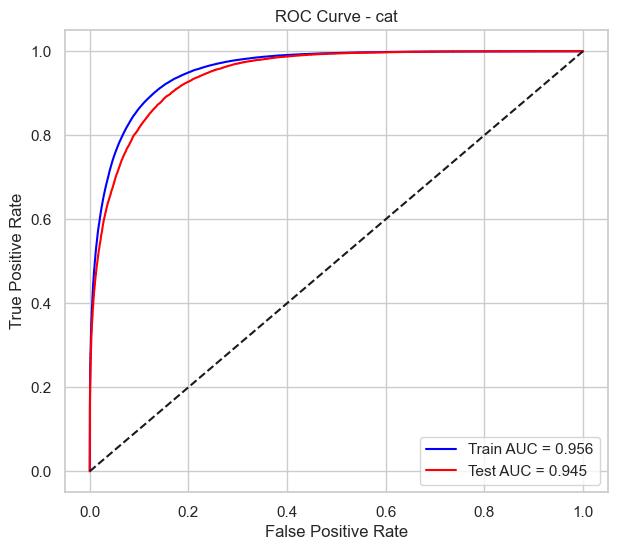

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# --- ROC Curve: Train vs Validation/Test ---
plt.figure(figsize=(7,6))

# Train
try:
    y_train_proba = best_pipe.predict_proba(X_train)[:,1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    auc_train = auc(fpr_train, tpr_train)
    plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.3f}", color='blue')
except:
    print("Model does not support predict_proba on train")

# Test
try:
    y_test_proba = best_pipe.predict_proba(X_test)[:,1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
    auc_test = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc_test:.3f}", color='red')
except:
    print("Model does not support predict_proba on test")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - {best_name}")
plt.legend(loc="lower right")
plt.show()



In [13]:
# ===== In your training notebook (ACC_87.ipynb), at the end =====

import os
import json
import joblib

# (This code replaces the content of your 10th cell)

# --- Ensure output directory exists ---
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Generate final predictions and report ---
y_pred = best_pipe.predict(X_test)
try:
    proba = best_pipe.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, proba)
except Exception:
    auc = None
acc = accuracy_score(y_test, y_pred)

report = {
    'model_name': best_name,
    'accuracy': float(acc),
    'roc_auc': float(auc) if auc is not None else None,
    'classification_report': classification_report(y_test, y_pred, output_dict=True, zero_division=0),
    'confusion_matrix': confusion_matrix(y_test, y_pred).tolist(),
    'baseline_scores': baseline_scores,
    'tuned_results': {k: (v[1] if v[1] is not None else None) for k,v in tuned_pipes.items()}
}

# --- 1. Save the best model pipeline ---
model_filename = os.path.join(OUTPUT_DIR, f'best_{best_name}.joblib')
joblib.dump(best_pipe, model_filename)

# --- 2. Save the final report ---
report_filename = os.path.join(OUTPUT_DIR, f'best_{best_name}_report.json')
with open(report_filename, 'w') as f:
    json.dump(report, f, indent=2)

# --- 3. Save the list of features the model needs ---
# This is a crucial new step for prediction
feature_list_filename = os.path.join(OUTPUT_DIR, 'model_features.json')
with open(feature_list_filename, 'w') as f:
    json.dump({'candidate_features': candidate_features}, f)

print(f"✅ Saved best model to: {model_filename}")
print(f"✅ Saved report to: {report_filename}")
print(f"✅ Saved feature list to: {feature_list_filename}")
print("\nReport summary: accuracy=", report['accuracy'], "auc=", report['roc_auc'])
# ================= END OF PIPELINE =================

✅ Saved best model to: ./bd_weather_output\best_cat.joblib
✅ Saved report to: ./bd_weather_output\best_cat_report.json
✅ Saved feature list to: ./bd_weather_output\model_features.json

Report summary: accuracy= 0.8703203147984702 auc= 0.9451730632645301


In [ ]:
# ===== In a NEW prediction script (e.g., predict.py) =====

import joblib
import pandas as pd
import json
import os
import numpy as np  # Required for np.sin/np.cos if you build features

# --- Configuration ---
OUTPUT_DIR = './bd_weather_output'
MODEL_NAME = 'best_cat.joblib'  # Use the name of your saved model
MODEL_PATH = os.path.join(OUTPUT_DIR, MODEL_NAME)
FEATURES_PATH = os.path.join(OUTPUT_DIR, 'model_features.json')

# --- 1. Load the Model and Feature List ---
print(f"Loading model from {MODEL_PATH}")
try:
    model = joblib.load(MODEL_PATH)
    with open(FEATURES_PATH, 'r') as f:
        features_data = json.load(f)
    candidate_features = features_data['candidate_features']
    print("✅ Model and feature list loaded successfully.")
except FileNotFoundError:
    print(f"Error: Could not find model or feature file. Please run the training notebook first.")
    exit()

# --- 2. Create New User Data ---
#
# IMPORTANT: Your model was trained on 28 engineered features
# (lags, rolling averages, cyclic features). To make a valid
# prediction, you must provide ALL of them.
#
# A real application would require a dedicated feature engineering
# pipeline to calculate these from raw data + historical data.
#
# For this test, we will create a single sample dictionary
# with plausible values for all 28 features.
#
new_user_data = {
    # Raw features
    'Station': 'Dhaka',
    'Year': 2024,
    'Month': 7,
    'Day': 15,
    'Sunshine': 4.5,
    'Humidity': 85.0,
    'Temperature': 29.5,
    
    # Cyclic features (calculated from Month/Day)
    'DayOfYear': 197,
    'WeekOfYear': 29,
    'month_sin': -0.5,
    'month_cos': -0.866,
    'day_sin': -0.207,
    'day_cos': 0.978,
    
    # Lag & Rolling features (MUST be based on data *before* 2024-07-15) 25
    'Rainfall_lag1': 0.0, #24  
    'Rainfall_lag2': 5.2, #23
    'Rainfall_lag3': 0.0, #22
    'Rainfall_rollmean_3': 1.73, # last 3 days avarage
    'Rainfall_rollmean_7': 2.5, # last 7 days avarage
    'Temperature_lag1': 30.0,
    'Temperature_lag2': 29.8,
    'Temperature_lag3': 30.1,
    'Temperature_rollmean_3': 29.97,
    'Temperature_rollmean_7': 29.5,
    'Humidity_lag1': 82.0,
    'Humidity_lag2': 88.0,
    'Humidity_lag3': 85.0,
    'Humidity_rollmean_3': 85.0,
    'Humidity_rollmean_7': 83.5
}

# --- 3. Format Data for the Model ---
# Convert the dictionary to a DataFrame
# The model's preprocessor pipeline expects this format.
try:
    new_data_df = pd.DataFrame(new_user_data, index=[0])
    
    # Ensure columns are in the EXACT order the model was trained on
    new_data_df = new_data_df[candidate_features]

    # --- 4. Make Predictions ---
    prediction = model.predict(new_data_df)
    probabilities = model.predict_proba(new_data_df)

    # --- 5. Show Results ---
    prediction_label = "Rain" if prediction[0] == 1 else "No Rain"
    probability_no_rain = probabilities[0][0] * 100
    probability_rain = probabilities[0][1] * 100

    print("\n--- Prediction Results ---")
    print(f"Prediction: {prediction_label} (Class {prediction[0]})")
    print(f"Confidence (No Rain): {probability_no_rain:.2f}%")
    print(f"Confidence (Rain):    {probability_rain:.2f}%")

except Exception as e:
    print(f"\nAn error occurred during prediction:")
    print(f"Error: {e}")
    print("\nEnsure 'new_user_data' contains all 28 required features with correct names.")
    print("Required Features:", candidate_features)

Loading model from ./bd_weather_output\best_cat.joblib
✅ Model and feature list loaded successfully.

--- Prediction Results ---
Prediction: Rain (Class 1)
Confidence (No Rain): 28.32%
Confidence (Rain):    71.68%


In [1]:
import pandas as pd
# Load the dataframe
df = pd.read_csv('./Dataset/BD_weather.csv')

# Get unique station names
station_names = df['Station'].unique()

# Print the unique station names
print(station_names)

['Ambaganctg' 'Barisal' 'Bhola' 'Bogra' 'Chandpur' 'Chittagong'
 'Chuadanga' 'Comilla' 'Coxsbazar' 'Dhaka' 'Dinajpur' 'Faridpur' 'Feni'
 'Hatiya' 'Ishurdi' 'Jessore' 'Khepupara' 'Khulna' 'Kutubdia' 'Madaripur'
 'Mcourt' 'Mongla' 'Mymensingh' 'Patuakhali' 'Rajshahi' 'Rangamati'
 'Rangpur' 'Sandwip' 'Satkhira' 'Sitakunda' 'Srimangal' 'Sydpur' 'Sylhet'
 'Tangail' 'Teknaf']
